---

## Cox Proportional Hazards and Random Survival Forests for estimation of the effect of covariates (features) on survival probabilities In-Hospital Mortality in ICU Patients

This notebook extends our survival analysis on the PhysioNet Challenge data, focusing on the advanced modeling of in-hospital mortality risk for patients in Intensive Care Units (ICU). Building upon the foundation of the Kaplan-Meier estimator, we now introduce Cox Proportional Hazards and Random Survival Forests models to examine the impact of various covariates on survival times and to make individual-level predictions.

### Approach
We will first employ the Cox Proportional Hazards model, allowing us to evaluate the effect of different factos (age, ICU unit, medical conditions, etc.) over the chance of an event (like death) happening. Bearing in mind that **the Cox model assumes the impact of such factors remains constant over time.**

Then, we will explore the Random Survival Forests method, which, unlike the Cox model, can handle non-linear relationships between the risk factors and the survival times. This will allow us to capture more complex relationships between the risk factors and the survival times.

Steps
### Cox Proportional Hazards Model:

1. **Model Fitting**: Apply the Cox model to understand the effects of covariates on survival.
2. **Assumption Verification**: Check the proportional hazards assumption integral to the model.
3. **Coefficient Interpretation**: Interpret the model coefficients to understand hazard ratios.
4. **Model Validation**: Validate the model's predictive performance using appropriate metrics.


### Random Survival Forests:

1. **Model Fitting and Tuning**: Fit the Random Survival Forest model and optimize its hyperparameters.
2. **Variable Importance**: Determine the importance of various covariates in predicting survival.
3. **Survival Prediction**: Predict survival probabilities for individual patients.
4. **Model Evaluation**: Evaluate the model's performance and compare it to the Cox model.

#### Again, the objective is to gain a nuanced understanding of factors influencing patient survival in the ICU, enabling more informed medical decision-making and improving care strategies through precise risk stratification and personalized survival predictions

---

## 0. Data Ingestion
We will be using the [PhysioNet Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/), which contains data from 4000 ICU patients. The dataset is provided in the form of a CSV file, which we will read into a Pandas DataFrame for further analysis.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from lifelines import CoxPHFitter



In [18]:
ICU_df = pd.read_csv('PhysionetChallenge2012-set-a.csv.gz', compression='gzip')

In [19]:
ICU_df.shape

(4000, 120)

## 1. Model Fitting: Apply the Cox model to understand the effects of features (covariates) on survival


### 1.1. Data Preprocessing: Preparing the dataset for Cox analysis

Identifying relevant features:
- General Descriptors: 'Age', 'Gender', 'Height', 'ICUType', 'Weight'
- Outcome Related Features: 'SAPS-I', 'SOFA'
- Top 10 Variables from Feature Importance RF: 'GCS_last', 'Length_of_stay', 'BUN_last', 'GCS_median', 'GCS_highest', 'BUN_first', 'WBC_last', 'Bilirubin_first', 'PaO2_first'

In [21]:
# Selecting the specified covariates
selected_covariates = [
    'Age', 'Gender', 'Height', 'CCU', 'CSRU', 'SICU', 'Weight',
    'SAPS-I', 'SOFA', 'GCS_last', 'Length_of_stay', 'BUN_last', 
    'GCS_median', 'GCS_highest', 'BUN_first', 'WBC_last', 
    'Bilirubin_first', 'PaO2_first'
]

In [22]:
# Checking for missing values in the selected covariates
missing_values = ICU_df[selected_covariates].isnull().sum()

missing_values

Age                   0
Gender                3
Height             1894
CCU                   0
CSRU                  0
SICU                  0
Weight              331
SAPS-I                0
SOFA                  0
GCS_last             64
Length_of_stay        0
BUN_last             64
GCS_median           64
GCS_highest          64
BUN_first            64
WBC_last             92
Bilirubin_first    2282
PaO2_first          977
dtype: int64

In [30]:
# Adjusting the threshold for missingness to 50%
threshold = 0.3 * len(ICU_df)

# Identifying variables to exclude based on the new threshold
variables_to_exclude = missing_values[missing_values > threshold].index.tolist()

# Dropping these variables
ICU_df_cleaned = ICU_df.drop(columns=variables_to_exclude)

# Imputing remaining missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
ICU_cleaned_imputed = pd.DataFrame(imputer.fit_transform(ICU_df_cleaned), columns=ICU_df_cleaned.columns)

# Checking the shape of the cleaned and imputed dataset
ICU_cleaned_imputed.shape

(4000, 118)

In [33]:
selected_covariates = [covariate for covariate in selected_covariates if covariate not in variables_to_exclude]
selected_covariates


['Age',
 'Gender',
 'Weight',
 'CCU',
 'CSRU',
 'SICU',
 'SAPS-I',
 'SOFA',
 'GCS_last',
 'Length_of_stay',
 'BUN_last',
 'GCS_median',
 'GCS_highest',
 'BUN_first',
 'WBC_last']

In [34]:
ICU_cox = ICU_cleaned_imputed[selected_covariates + ['Survival', 'In-hospital_death']].copy()
ICU_cox.head()

,Age,Gender,Weight,CCU,CSRU,SICU,SAPS-I,SOFA,GCS_last,Length_of_stay,BUN_last,GCS_median,GCS_highest,BUN_first,WBC_last,Survival,In-hospital_death
0,54.0,0.0,81.474832,0.0,0.0,1.0,6.0,1.0,15.0,5.0,8.0,15.0,15.0,13.0,9.4,-1.0,0.0
1,76.0,1.0,76.000000,0.0,1.0,0.0,16.0,8.0,15.0,8.0,21.0,15.0,15.0,16.0,13.3,-1.0,0.0
2,44.0,0.0,56.700000,0.0,0.0,0.0,21.0,11.0,5.0,19.0,3.0,5.0,8.0,8.0,6.2,-1.0,0.0
3,68.0,1.0,84.600000,0.0,0.0,0.0,7.0,1.0,15.0,9.0,10.0,15.0,15.0,23.0,7.9,575.0,0.0
4,88.0,0.0,81.474832,0.0,0.0,0.0,17.0,2.0,15.0,4.0,25.0,15.0,15.0,45.0,4.8,918.0,0.0


### 1.2. Fitting the Cox Model

In [38]:
# Creating the Cox Proportional Hazards model
cph = CoxPHFitter()

# 'Survival' is the duration and 'In-hospital_death' is the event indicator
cph.fit(ICU_cox, duration_col='Survival', event_col='In-hospital_death')

# Display the model summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4000 total observations, 3446 right-censored observations>
             duration col = 'Survival'
                event col = 'In-hospital_death'
      baseline estimation = breslow
   number of observations = 4000
number of events observed = 554
   partial log-likelihood = -3679.28
         time fit was run = 2023-11-29 21:44:25 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age             -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
Gender          -0.02       0.98       0.09            -0.19             0.15                 0.83                 1.17
Weight          -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
CCU             -0.20       0.82       0.13            -0.46             0.05                 0.63                 1.05
CSRU            -0.62       0.54       0.17            -0.96            -0.28                 0.38                 0.76
SICU             0.21       1.23       0.11            -0.00             0.42                 1.00                 1.52
SAPS-I          -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
SOFA             0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
GCS_last        -0.21       0.81       0.02            -0.25            -0.17                 0.78                 0.84
Length_of_stay  -0.04       0.96       0.00            -0.05            -0.03                 0.95                 0.97
BUN_last         0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
GCS_median       0.05       1.05       0.03             0.00             0.10                 1.00                 1.11
GCS_highest     -0.02       0.98       0.02            -0.07             0.02                 0.94                 1.02
BUN_first       -0.01       0.99       0.00            -0.01             0.00                 0.99                 1.00
WBC_last         0.02       1.02       0.00             0.01             0.03                 1.01                 1.03

                 cmp to      z      p   -log2(p)
covariate                                       
Age                0.00  -0.54   0.59       0.76
Gender             0.00  -0.21   0.83       0.26
Weight             0.00  -2.01   0.04       4.51
CCU                0.00  -1.58   0.11       3.14
CSRU               0.00  -3.56 <0.005      11.42
SICU               0.00   1.93   0.05       4.23
SAPS-I             0.00  -0.58   0.56       0.83
SOFA               0.00   2.62   0.01       6.83
GCS_last           0.00 -11.06 <0.005      92.07
Length_of_stay     0.00  -8.34 <0.005      53.56
BUN_last           0.00   3.45 <0.005      10.82
GCS_median         0.00   1.96   0.05       4.33
GCS_highest        0.00  -1.13   0.26       1.95
BUN_first          0.00  -1.41   0.16       2.65
WBC_last           0.00   4.41 <0.005      16.53
---
Concordance = 0.75
Partial AIC = 7388.57
log-likelihood ratio test = 455.12 on 15 df
-log2(p) of ll-ratio test = 288.23

(0.0, 180.0)

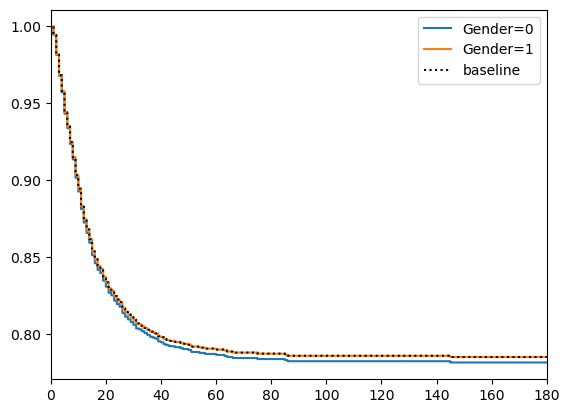

In [44]:
cph.plot_covariate_groups('Gender', values=[0, 1]);
plt.xlim(0, 180)

<Figure size 1000x600 with 0 Axes>

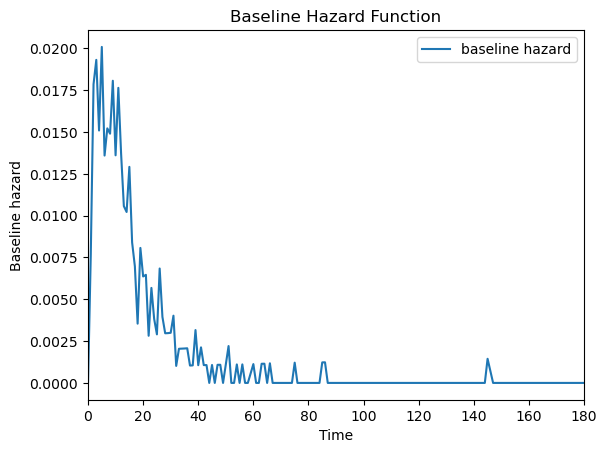

In [47]:
baseline_hazard = cph.baseline_hazard_

# Plotting the baseline hazard function
plt.figure(figsize=(10, 6))
baseline_hazard.plot()
plt.title('Baseline Hazard Function')
plt.xlabel('Time')
plt.ylabel('Baseline hazard')
plt.xlim(0, 180)

plt.show()

Adding realtive predictive risk scores to our dataset

In [39]:
predicted_risks = cph.predict_partial_hazard(ICU_cox)

# Adding  predicted risks to the DataFrame for easier interpretation
ICU_cox['Relative_Risk'] = predicted_risks.values.flatten()

ICU_cox.head()


,Age,Gender,Weight,CCU,CSRU,SICU,SAPS-I,SOFA,GCS_last,Length_of_stay,BUN_last,GCS_median,GCS_highest,BUN_first,WBC_last,Survival,In-hospital_death,Relative_Risk
0,54.0,0.0,81.474832,0.0,0.0,1.0,6.0,1.0,15.0,5.0,8.0,15.0,15.0,13.0,9.4,-1.0,0.0,0.879606
1,76.0,1.0,76.000000,0.0,1.0,0.0,16.0,8.0,15.0,8.0,21.0,15.0,15.0,16.0,13.3,-1.0,0.0,0.514492
2,44.0,0.0,56.700000,0.0,0.0,0.0,21.0,11.0,5.0,19.0,3.0,5.0,8.0,8.0,6.2,-1.0,0.0,3.176509
3,68.0,1.0,84.600000,0.0,0.0,0.0,7.0,1.0,15.0,9.0,10.0,15.0,15.0,23.0,7.9,575.0,0.0,0.543076
4,88.0,0.0,81.474832,0.0,0.0,0.0,17.0,2.0,15.0,4.0,25.0,15.0,15.0,45.0,4.8,918.0,0.0,0.656843


## 4. Survival Curve Plotting: Visualizing the survival curve to interpret how survival probabilities change over time

## 5. Result Interpretation: Discussing the implications of the survival curve in the context of in-hospital mortality in ICU settings
Interpreingt the Kaplan-Meier survival plot and understand what it indicates about the patient cohort

1. **Early Decline**: What factors might contribute to early mortality in ICU patients e.g. severity of illness, emergency admissions
2. **Plateau Phase**: What factors may help explaining the plateau in the survival curve? e.g. patients with better long-term prognosis
3. **Long-term Survivors**: What does it indicate when the survival probability becomes flat? e.g. patients who survived for a long duration
4. **Censoring**: What's the impact of censored data on the survival estimates, especially towards the end of the study period?
5. **Clinical Implications**: **SO WHAT!?** How these survival probabilities can inform clinical practice, patient counseling, and healthcare policy